Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from collections import Counter
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Loading Data

In [ ]:
patients_data=pd.read_csv("/content/patient_notes.csv")

EDA

In [ ]:
print(patients_data.head())

   pn_num  case_num                                         pn_history
0       0         0  17-year-old male, has come to the student heal...
1       1         0  17 yo male with recurrent palpitations for the...
2       2         0  Dillon Cleveland is a 17 y.o. male patient wit...
3       3         0  a 17 yo m c/o palpitation started 3 mos ago; \...
4       4         0  17yo male with no pmh here for evaluation of p...


In [ ]:
#missing values
missing_values=patients_data.isnull().sum()
print(missing_values)

pn_num        0
case_num      0
pn_history    0
dtype: int64


In [ ]:
#missing rows
patients_data.dropna(subset=['pn_history'])

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...
...,...,...,...
42141,95330,9,Ms. Madden is a 20 yo female presenting w/ the...
42142,95331,9,A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...
42143,95332,9,Ms. Madden is a 20yo female who presents with ...
42144,95333,9,Stephanie madden is a 20 year old woman compla...


In [ ]:
#duplicates
patients_data.drop_duplicates(subset=['pn_history'],inplace=True)

In [ ]:
#normalizing
patients_data['pn_history'] = patients_data['pn_history'].str.lower().str.replace('[^\w\s]', '', regex=True)


In [ ]:
patients_data['text_length'] = patients_data['pn_history'].apply(len)
print(patients_data['text_length'].describe())

count    42146.000000
mean       785.400489
std        132.957207
min         29.000000
25%        705.000000
50%        824.000000
75%        900.000000
max        939.000000
Name: text_length, dtype: float64


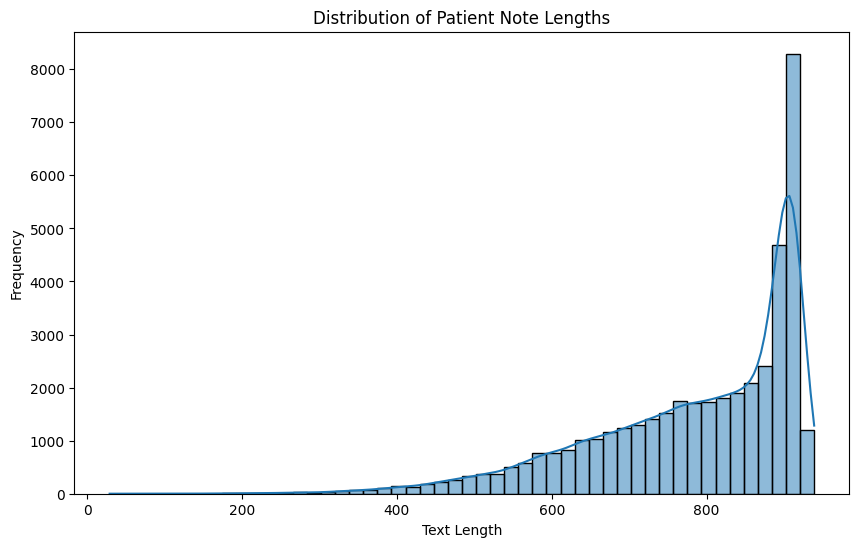

In [ ]:
#distribution of text lenths
plt.figure(figsize=(10, 6))
sns.histplot(patients_data['text_length'], bins=50, kde=True)
plt.title('Distribution of Patient Note Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Word analysis

In [ ]:
stop_words = set(stopwords.words('english'))
patients_data['tokenized'] = patients_data['pn_history'].apply(lambda x: [word for word in x.split() if word not in stop_words])

In [ ]:
all_words = [word for tokens in patients_data['tokenized'] for word in tokens]

In [ ]:
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)
print("Most common words:\n", common_words)

Most common words:
 [('pain', 77390), ('none', 55401), ('denies', 51713), ('ago', 44320), ('2', 39328), ('weeks', 30787), ('pmh', 28726), ('changes', 27432), ('months', 26767), ('last', 26050), ('yo', 25551), ('use', 24525), ('ros', 23437), ('patient', 22470), ('meds', 22462), ('past', 21599), ('3', 21587), ('years', 19689), ('fh', 18723), ('active', 18667)]


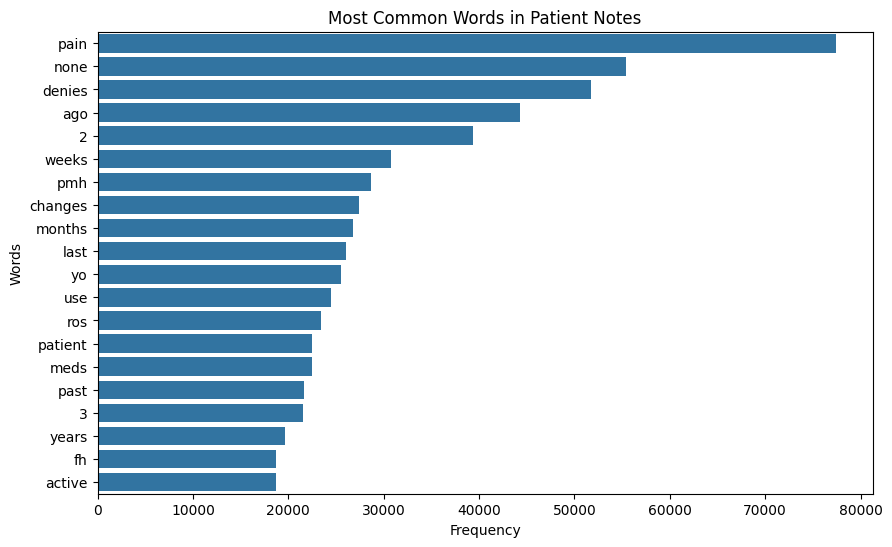

In [ ]:
#most common words
words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Most Common Words in Patient Notes')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Word cloud

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(' '.join(all_words))


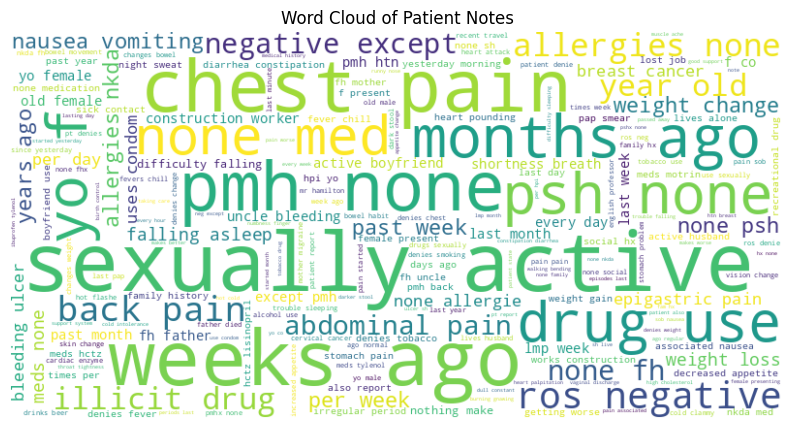

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Patient Notes')
plt.show()

Case number analysis

In [ ]:
case_counts = patients_data['case_num'].value_counts()

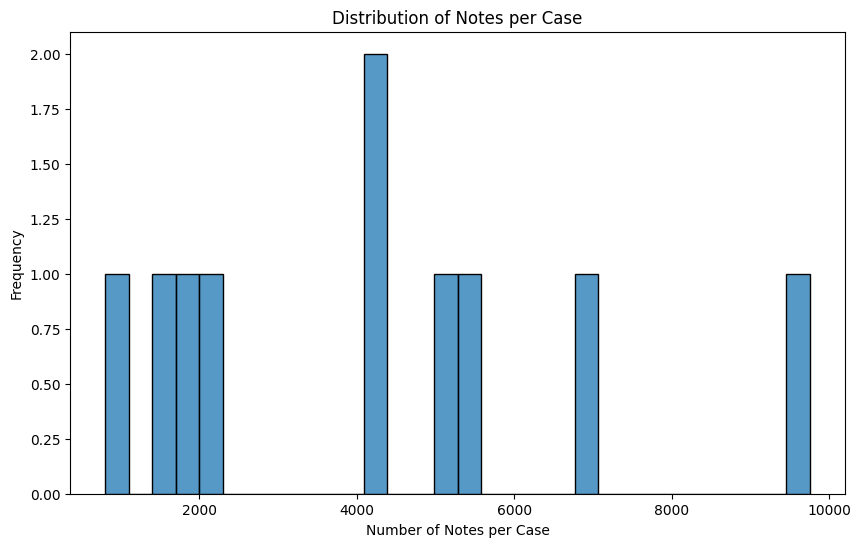

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(case_counts, bins=30, kde=False)
plt.title('Distribution of Notes per Case')
plt.xlabel('Number of Notes per Case')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(case_counts.describe())

count      10.00000
mean     4214.60000
std      2740.21618
min       808.00000
25%      2035.50000
50%      4148.50000
75%      5341.50000
max      9753.00000
Name: count, dtype: float64


Text summary analysis

In [ ]:
avg_note_length_by_case = patients_data.groupby('case_num')['text_length'].mean()

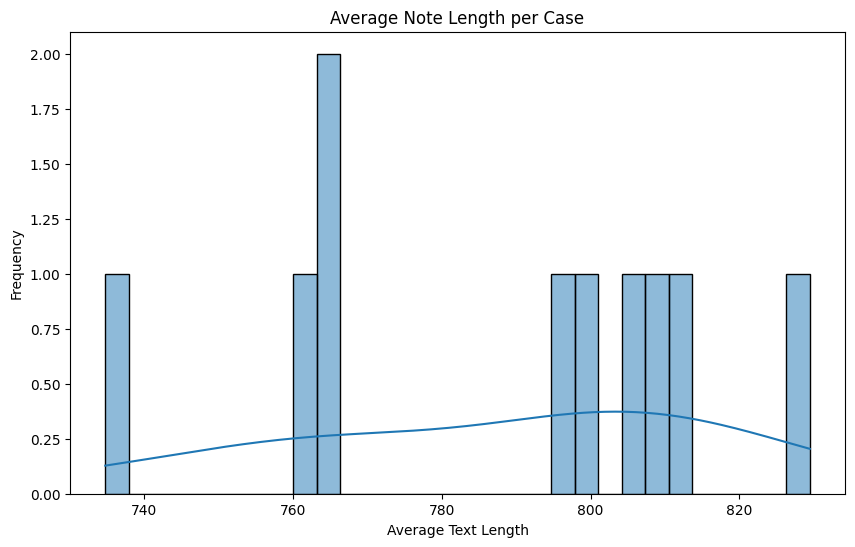

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(avg_note_length_by_case, bins=30, kde=True)
plt.title('Average Note Length per Case')
plt.xlabel('Average Text Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
top_longest_cases = avg_note_length_by_case.sort_values(ascending=False).head(5)
print("Top 5 cases with the longest average note length:\n", top_longest_cases)

Top 5 cases with the longest average note length:
 case_num
8    829.461868
7    810.869300
2    808.126149
0    804.497795
4    799.941536
Name: text_length, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
patients_data['summary'] = patients_data['pn_history'].apply(lambda x: x[:150])

In [ ]:
train_df, val_df = train_test_split(patients_data, test_size=0.1, random_state=42)

In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset

In [ ]:
#converting to hugging face data format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments

In [ ]:
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
def tokenize_data(example):
    inputs = tokenizer(example['pn_history'], max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(example['summary'], max_length=150, truncation=True, padding="max_length")
    inputs['labels'] = labels['input_ids']
    return inputs


In [ ]:
train_dataset = train_dataset.map(tokenize_data, batched=True)
val_dataset = val_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/37931 [00:00<?, ? examples/s]

Map:   0%|          | 0/4215 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.046000,0.045955
2,0.038900,0.040609
3,0.037400,0.038127


TrainOutput(global_step=28449, training_loss=0.06861748715989716, metrics={'train_runtime': 2208.5944, 'train_samples_per_second': 51.523, 'train_steps_per_second': 12.881, 'total_flos': 1.5400949614903296e+16, 'train_loss': 0.06861748715989716, 'epoch': 3.0})

In [ ]:
results=trainer.evaluate()

In [ ]:
def generate_summary(batch):
    inputs = tokenizer(batch["pn_history"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)

   #generating the summaries
    outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=150)

    #decoding the summaries
    batch["predicted_summary"] = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

    return batch


In [ ]:
val_results = val_dataset.map(generate_summary, batched=True, batch_size=4)


Map:   0%|          | 0/4215 [00:00<?, ? examples/s]

In [ ]:
for i in range(5):
    # Accessing the elements
    original_text = val_results[i].get('pn_history', 'N/A')  # Safe access with .get
    generated_summary = val_results[i].get('predicted_summary', 'N/A')
    reference_summary = val_results[i].get('summary', 'N/A')

    # Printing the results
    print(f"Original: {original_text}")
    print(f"Generated Summary: {generated_summary}")
    print(f"Reference Summary: {reference_summary}\n")

Original: N/A
Generated Summary: 35yo m co stomach problems since 2months started gradually and is worsening he is experiencing pain in the upper middle part of the abdomen which of medium grade 5
Reference Summary: N/A

Original: N/A
Generated Summary: patient is a 17yo male presenting with chest pain started yesterday morning it is a sharp pain that worsenes with movement and deep breaths tried tylenol
Reference Summary: N/A

Original: N/A
Generated Summary: cc 67yearold female co trouble sleeping hpi began 3 weeks ago has trouble falling asleep in bed for an hour before sleeping does not engages in activities in bed
Reference Summary: N/A

Original: N/A
Generated Summary: hpi 45 yo f co nervousness that started a few weeks ago after he change roles at work and its now teaching she feels anxious all the time nothing makes it
Reference Summary: N/A

Original: N/A
Generated Summary: mr cleveland is a 17 yo male who presents due to a 23 month hx of heart pounding he feels like his heart